In [1]:
import sys
import os

import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

In [2]:
import torch
import torch.nn as nn

In [3]:
sys.path.append(os.path.abspath("../.."))
from utils import read_features, read_targets, train_val_split, get_dimensions, scale, metrics_c, get_device, \
    plot_history, load_best_params, plot_mlp_comparison, d_types_methods, get_color_map, evaluate, \
    plot_prediction_scores, get_result_subsets, print_top_1, plot_true_vs_pred, get_results_table, get_model_path, \
    plot_confusion_matrix, plot_confusion_matrix_dual_cmap, print_info_features, read_target_tensors, print_info_targets

In [4]:
sys.path.append(os.path.abspath(".."))
from PotteryDataset import create_pottery_dataloaders, create_pottery_datasets, feature_types, feature_type_combos
from PotteryChronologyPredictor import PotteryChronologyPredictor, predict, activation_funcs, predict_mc

## Settings

In [5]:
# Current Working Device
device = get_device()

PyTorch Version: 2.5.1
CUDA is available
GPU: NVIDIA GeForce RTX 4080
Using Device: cuda


In [6]:
# Data Path
path_features = os.path.abspath(os.path.join(os.getcwd(), "../../../data/features2"))
path_targets = os.path.abspath(os.path.join(os.getcwd(), "../../../data/targets/classification"))

# Model Path
path_models = os.path.abspath(os.path.join(os.getcwd(), "models"))
os.makedirs(path_models, exist_ok=True)
model_name = "pottery_chronology_classifier"

In [7]:
# Targets
target = "HistoricalPeriod"

In [8]:
# Training Loss Function and Extra Metrics
criterion = nn.CrossEntropyLoss()
metrics = metrics_c

## Data

### Read Features and Targets

In [9]:
X = read_features(path_features, f_type="tensors")
print_info_features(X)

Loaded X_train_tfidf
Loaded X_train_bert
Loaded X_train_cannyhog
Loaded X_train_resnet
Loaded X_train_vit
Loaded X_val_tfidf
Loaded X_val_bert
Loaded X_val_cannyhog
Loaded X_val_resnet
Loaded X_val_vit
Loaded X_test_tfidf
Loaded X_test_bert
Loaded X_test_cannyhog
Loaded X_test_resnet
Loaded X_test_vit
{
	train: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([1528, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([1528, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([1528, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([1528, 2048]), 
		vit: 
			<class 'torch.Tensor'>
			shape = torch.Size([1528, 768]), 
	},
	val: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 2048]), 
		vit: 
			<

In [10]:
y = read_target_tensors(path_targets)
print_info_targets(y)

Loaded y_train
Loaded y_val
Loaded y_test
{
	train: 
		<class 'torch.Tensor'>
		shape   = torch.Size([1528])
	val: 
		<class 'torch.Tensor'>
		shape   = torch.Size([191])
	test: 
		<class 'torch.Tensor'>
		shape   = torch.Size([191])
}


### Load Target Encoder

In [11]:
path_encoder = os.path.join(path_targets, "y_encoder.pkl")
y_encoder = joblib.load(path_encoder)

### Dimensions

In [12]:
X_dim, y_dim = get_dimensions(X, y, y_encoder)

X Dimensions: {'tfidf': 300, 'bert': 768, 'cannyhog': 2917, 'resnet': 2048, 'vit': 768}
y Dimensions: 4


### Torch Datasets and Dataloaders

In [13]:
datasets = create_pottery_datasets(X, y)
loaders = create_pottery_dataloaders(datasets, batch_size=64)

### Target to Numpy for comparing Predictions

In [18]:
y = {subset: _y.cpu().numpy() for subset, _y in y.items()}

print_info_targets(y)

{
	train: 
		<class 'numpy.ndarray'>
		shape   = (1528,)
	val: 
		<class 'numpy.ndarray'>
		shape   = (191,)
	test: 
		<class 'numpy.ndarray'>
		shape   = (191,)
}


## Best Params from Tuning

In [19]:
# Load Saved Best Params
path_params = os.path.join(path_models, "best_params.json")
best_params = load_best_params(path_params)

## Text Input MLP Model

### Rebuild Model, Load Weights & Predict

activation                 relu
blocks                        1
dropout                     0.1
hidden_size                1024
hidden_size_pattern    constant
lr                         0.01
Name: value, dtype: object
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
PotteryChronologyPredictor               [1, 300]                  [1, 4]                    --                        --
├─ModuleList: 1-1                        --                        --                        --                        --
│    └─Sequential: 2-1                   [1, 300]                  [1, 1024]                 --                        --
│    │    └─Linear: 3-1                  [1, 300]                  [1, 1024]                 308,224                   308,224
│    │    └─ReLU: 3-2                    [1, 1024]                 [1, 1024]                 --                        --
│    │    └─Dropout: 3-3             

[Test]:   0%|          | 0/3 [00:00<?, ?it/s]

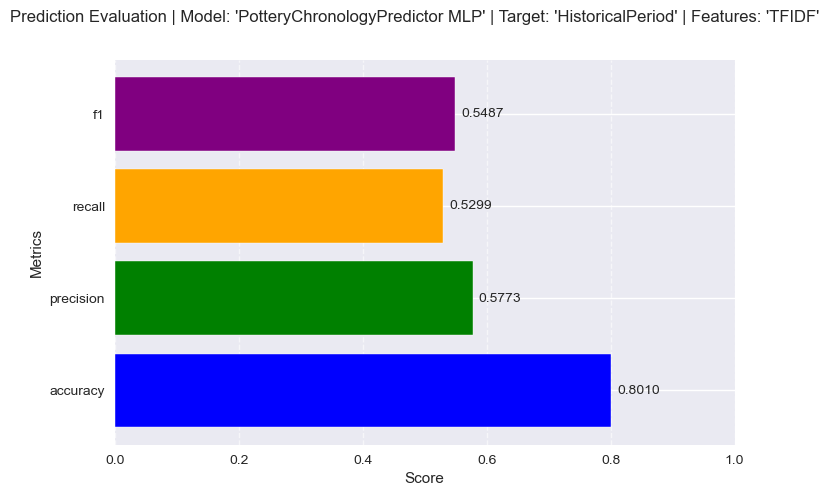

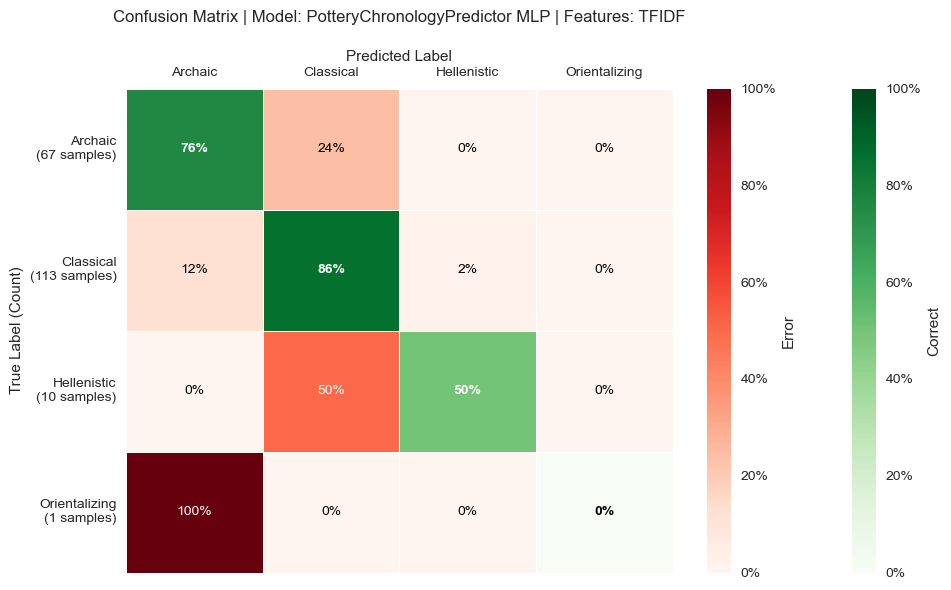

In [20]:
ft = "tfidf"
params = best_params[ft]["params"]
print(pd.Series(params, name="value"))

# Build Model
model = PotteryChronologyPredictor(
    [X_dim[ft]],
    y_dim,
    params["hidden_size"],
    device=device,
    activation=activation_funcs[params["activation"]],
    dropout=params["dropout"],
    blocks=params["blocks"],
    hidden_size_pattern=params["hidden_size_pattern"],
    chronology_target="periods"
)

model.summary()

# Load Weights
model.load_state_dict(torch.load(get_model_path(path_models, model_name, ft), weights_only=True))
model.eval()

print(f"✅ Loaded {ft.upper()}-Input Model. Ready for testing!")

# Predict Test Set
y_pred = predict(model, loaders["test"][ft])

# Evaluate
scores = evaluate(y["test"], y_pred, metrics_c)
plot_prediction_scores(scores, "PotteryChronologyPredictor MLP", target, ft)

# Confusion Matrix
cm = confusion_matrix(y["test"], y_pred)
# plot_confusion_matrix(cm, le, "PotteryChronologyPredictor MLP", ft)
plot_confusion_matrix_dual_cmap(cm, y_encoder, "PotteryChronologyPredictor MLP", ft)

## Image Input MLP Model

### Rebuild Model, Load Weights & Predict

activation                 relu
blocks                        1
dropout                     0.1
hidden_size                1024
hidden_size_pattern    constant
lr                        0.005
Name: value, dtype: object
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
PotteryChronologyPredictor               [1, 768]                  [1, 4]                    --                        --
├─ModuleList: 1-1                        --                        --                        --                        --
│    └─Sequential: 2-1                   [1, 768]                  [1, 1024]                 --                        --
│    │    └─Linear: 3-1                  [1, 768]                  [1, 1024]                 787,456                   787,456
│    │    └─ReLU: 3-2                    [1, 1024]                 [1, 1024]                 --                        --
│    │    └─Dropout: 3-3             

[Test]:   0%|          | 0/3 [00:00<?, ?it/s]

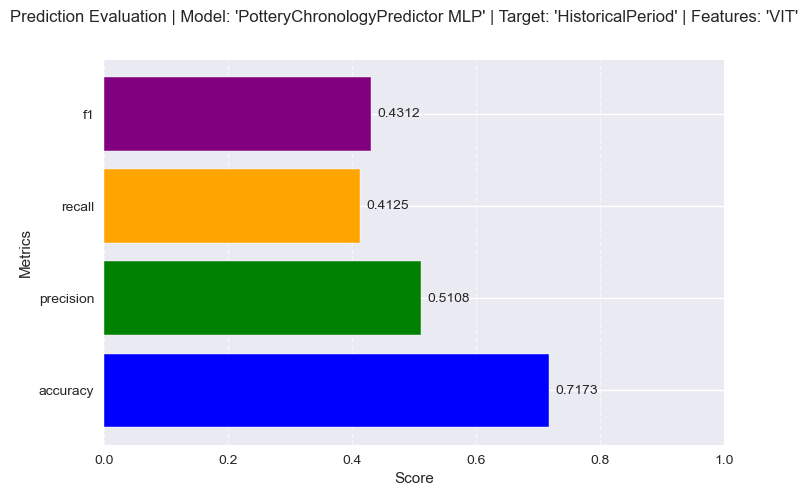

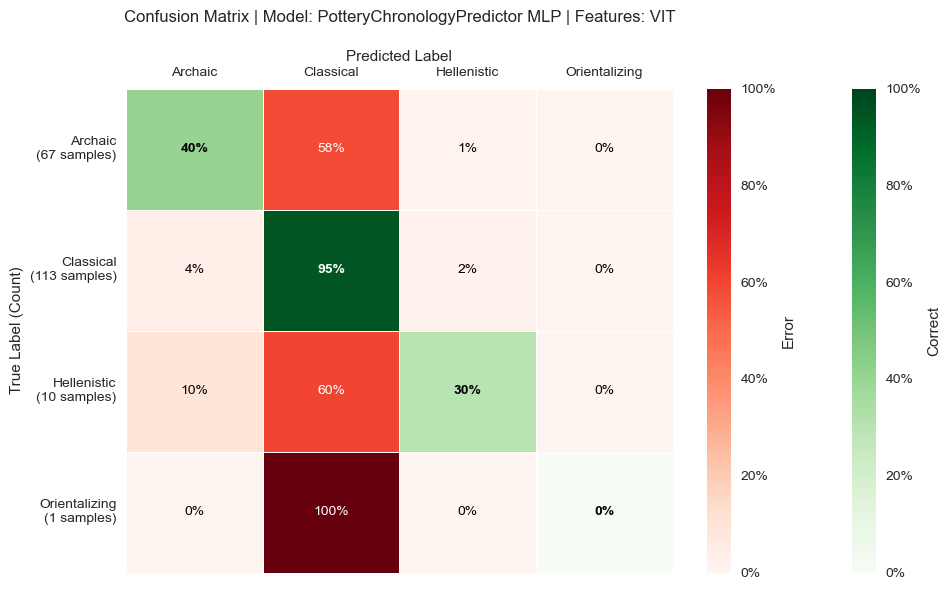

In [21]:
ft = "vit"
params = best_params[ft]["params"]
print(pd.Series(params, name="value"))

# Build Model
model = PotteryChronologyPredictor(
    [X_dim[ft]],
    y_dim,
    params["hidden_size"],
    device=device,
    activation=activation_funcs[params["activation"]],
    dropout=params["dropout"],
    blocks=params["blocks"],
    hidden_size_pattern=params["hidden_size_pattern"],
    chronology_target="periods"
)

model.summary()

# Load Weights
model.load_state_dict(torch.load(get_model_path(path_models, model_name, ft), weights_only=True))
model.eval()

print(f"✅ Loaded {ft.upper()}-Input Model. Ready for testing!")

# Predict Test Set
y_pred = predict(model, loaders["test"][ft])

# Evaluate
scores = evaluate(y["test"], y_pred, metrics_c)
plot_prediction_scores(scores, "PotteryChronologyPredictor MLP", target, ft)

# Confusion Matrix
cm = confusion_matrix(y["test"], y_pred)
plot_confusion_matrix_dual_cmap(cm, y_encoder, "PotteryChronologyPredictor MLP", ft)

## Text + Image Combo Input MLP Model

### Rebuild Model, Load Weights & Predict

activation                   gelu
blocks                          2
dropout                       0.2
hidden_size                   256
hidden_size_pattern    decreasing
lr                           0.01
Name: value, dtype: object
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
PotteryChronologyPredictor               [1, 300]                  [1, 4]                    --                        --
├─ModuleList: 1-1                        --                        --                        --                        --
│    └─Sequential: 2-1                   [1, 300]                  [1, 256]                  --                        --
│    │    └─Linear: 3-1                  [1, 300]                  [1, 256]                  77,056                    77,056
│    │    └─GELU: 3-2                    [1, 256]                  [1, 256]                  --                        --
│    │    └─Dropout: 3-3  

[Test]:   0%|          | 0/3 [00:00<?, ?it/s]

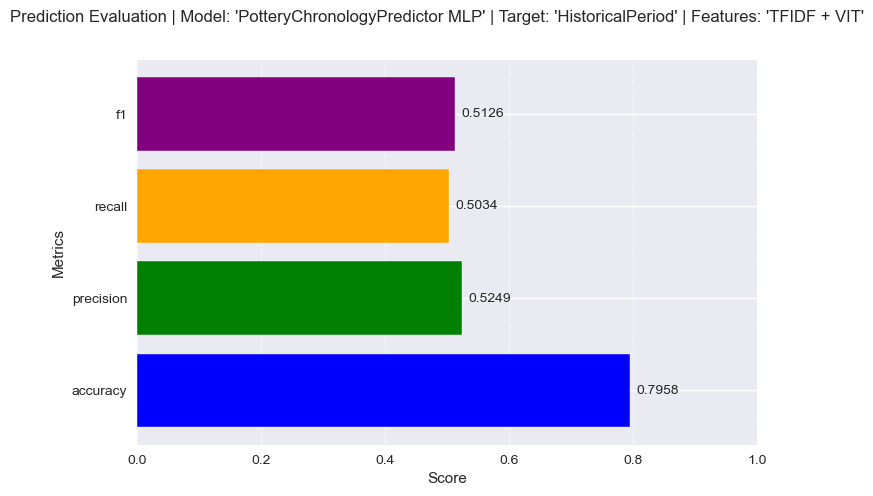

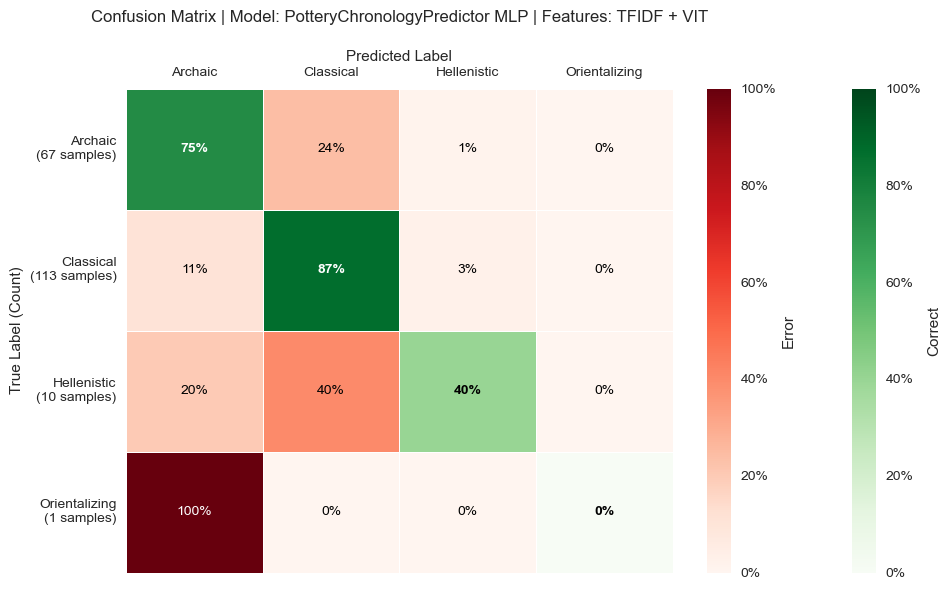

In [22]:
fts = ["tfidf", "vit"]
ft = " + ".join(fts)
params = best_params[ft]["params"]
print(pd.Series(params, name="value"))

# Build Model
model = PotteryChronologyPredictor(
    [X_dim[_ft] for _ft in fts],
    y_dim,
    params["hidden_size"],
    device=device,
    activation=activation_funcs[params["activation"]],
    dropout=params["dropout"],
    blocks=params["blocks"],
    hidden_size_pattern=params["hidden_size_pattern"],
    chronology_target="periods"
)

model.summary()

# Load Weights
model.load_state_dict(torch.load(get_model_path(path_models, model_name, "_".join(fts)), weights_only=True))
model.eval()

print(f"✅ Loaded {ft.upper()}-Input Model. Ready for testing!")

# Predict Test Set
y_pred = predict(model, loaders["test"][ft])

# Evaluate
scores = evaluate(y["test"], y_pred, metrics_c)
plot_prediction_scores(scores, "PotteryChronologyPredictor MLP", target, ft)

# Confusion Matrix
cm = confusion_matrix(y["test"], y_pred)
plot_confusion_matrix_dual_cmap(cm, y_encoder, "PotteryChronologyPredictor MLP", ft)